In [1]:
# import sys
# !{sys.executable} -m pip install -r requirements.txt

Find the'Cat03.jpg'
'Cat03.jpg' loaded，shape: (1598, 1600, 3)


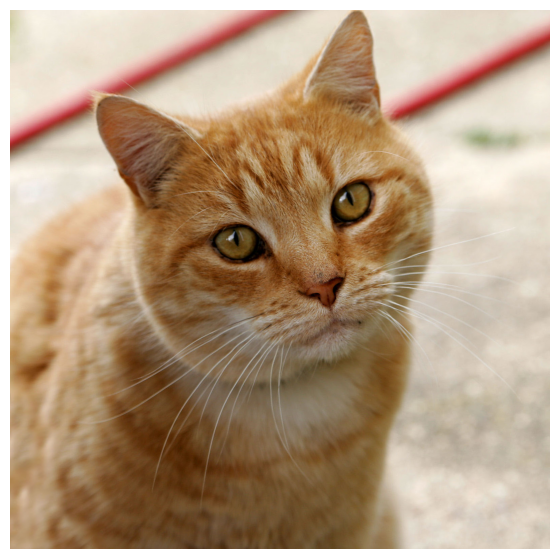

In [2]:
import torch
import clip
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from urllib.request import urlretrieve
import warnings

try:
    from models import load_clip, load_sam_automask_generator, get_device
except ImportError:
    print("Error: cannot import")
    print("Please ensure that this Notebook and the 'src' folder are in the same root directory.")

def check_local_image(target_path):
    """
    Check if the image exist
    """
    if not os.path.exists(target_path):
        print(f"Cannot find the image")
        return False
    else:
        print(f"Find the'{target_path}'")
        return True

def load_image(image_path):
    """
    RGB
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


TEST_IMAGE_PATH = "Cat03.jpg"  

if check_local_image(TEST_IMAGE_PATH):
    # 加载图片
    image_rgb = load_image(TEST_IMAGE_PATH)
    
    if image_rgb is not None:
        print(f"'{TEST_IMAGE_PATH}' loaded，shape: {image_rgb.shape}")
        
        # 显示图片
        plt.figure(figsize=(7, 7))
        plt.imshow(image_rgb)
        plt.axis("off")
        plt.show()
    else:
        print(f"Cannot load image: {YOUR_LOCAL_IMAGE_PATH}")
        image_rgb = None 
else:
     image_rgb = None 

In [3]:
def apply_mask_to_image(image, mask):
    """
    将二进制蒙版应用于图像，裁剪出蒙版区域。
    返回一个 PIL Image，以便 CLIP 预处理器使用。
    """
    if mask.ndim == 3:
        mask = mask.squeeze()
    masked_image = np.zeros((*image.shape[:2], 4), dtype=np.uint8)
    masked_image[..., :3] = image
    masked_image[mask, 3] = 255
    return Image.fromarray(masked_image, 'RGBA')

def show_anns(image, anns, title=""):
    """
    在图像上显示所有 SAM 蒙版。
    """
    if not anns:
        print("没有找到蒙版。")
        return
    sorted_anns = sorted(anns, key=(lambda x: x['predicted_iou']), reverse=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(title, fontsize=16)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    plt.axis('off')
    plt.show()

def show_best_mask(image, mask, score, text_prompt):
    """
    显示原始图像和得分最高的蒙版。
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("original", fontsize=14)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    result_image = np.zeros_like(image)
    result_image[mask] = image[mask]
    plt.imshow(result_image)
    plt.title(f"Result: \"{text_prompt}\"\nCLIP Score: {score:.4f}", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


--- Step 2: Load model ---
正在加载 CLIP 模型 'ViT-B/32' 到设备: cuda...
CLIP 模型加载成功。
正在加载 SAM 模型 'vit_b' (Small Version) 到设备: cuda...
SAM checkpoint 'sam_vit_b_01ec64.pth' (vit_b) 已存在。
SAM Automatic Mask Generator (vit_b) 加载成功。
--- Model loaded successful ---
--- Step 3: SAM creating the mask... ---
SAM generated 15 masking。
Show the all masking...


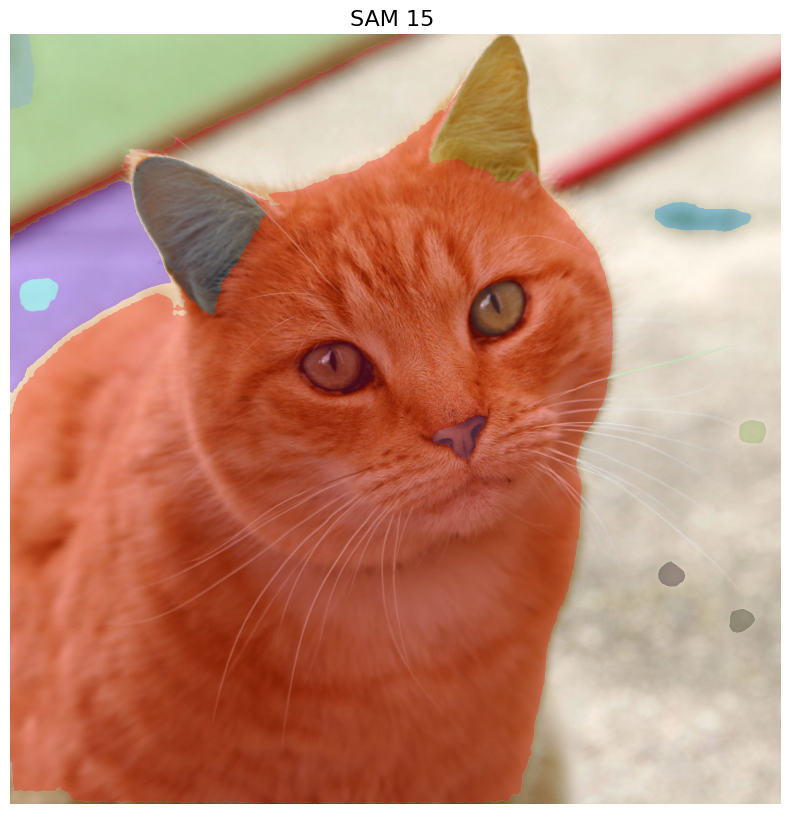

In [4]:
print("--- Step 2: Load model ---")
clip_model, clip_preprocess, clip_device = load_clip()
mask_generator, sam_device = load_sam_automask_generator() 

if not all([clip_model, mask_generator]):
    print("Failed...")
else:
    print("--- Model loaded successful ---")

print("--- Step 3: SAM creating the mask... ---")
# The SAM generator requires images in BGR format.
image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
sam_masks = mask_generator.generate(image_bgr)

if not sam_masks:
    print("SAM cannot generate the masking。")
else:
    print(f"SAM generated {len(sam_masks)} masking。")

print("Show the all masking...")
show_anns(image_rgb, sam_masks, title=f"SAM {len(sam_masks)} ")

In [5]:
print(f"--- Step 4: CLIP Define the language prompt... ---")
text_prompt = "cat"

text = clip.tokenize([text_prompt]).to(clip_device)

with torch.no_grad():
    text_features = clip_model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)

print(f"文本提示: \"{text_prompt}\"")

# %%
print(f"--- Step 5: CLIP is processing all {len(sam_masks)} mask images... ---")

processed_images = []

for ann in sam_masks:
    mask = ann['segmentation'] # (H, W) boolean
    cropped_pil_image = apply_mask_to_image(image_rgb, mask)
    processed_images.append(clip_preprocess(cropped_pil_image))

# Create a batch
image_batch = torch.stack(processed_images).to(clip_device)
print(f"A Batch of {len(image_batch)} cropped images was created")

print("\n--- Step 6: CLIP is calculating the similarity score... ---")
with torch.no_grad():
    # Encode all the cropped images
    image_features = clip_model.encode_image(image_batch)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    
    # Calculate the cosine similarity between text features and all image features
    similarity = (100.0 * text_features @ image_features.T).softmax(dim=-1)
    
# (1, N) -> (N,)
scores = similarity.squeeze()
print("The score calculation is complete.")
print(f"Score:{scores}")

--- Step 4: CLIP Define the language prompt... ---
文本提示: "cat"
--- Step 5: CLIP is processing all 15 mask images... ---
A Batch of 15 cropped images was created

--- Step 6: CLIP is calculating the similarity score... ---
The score calculation is complete.
Score:tensor([0.0259, 0.0044, 0.0359, 0.0186, 0.0038, 0.0097, 0.0047, 0.0523, 0.0377,
        0.0178, 0.0078, 0.0078, 0.0232, 0.0289, 0.7217], device='cuda:0',
       dtype=torch.float16)


--- Step 7: Find the best match... ---
Find best index: 14, score: 0.7217

--- Step 8: Display the results ---


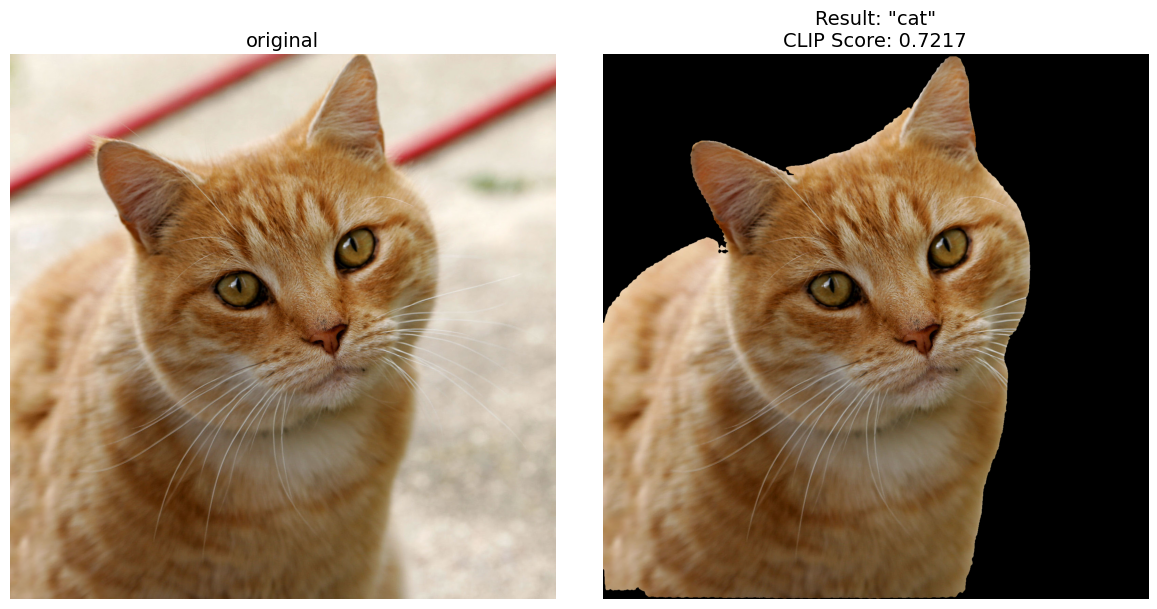

In [6]:
# ## 8. Step 7 & 8: Search for and display the best results
#
# Find the mask with the highest score and display it.

print("--- Step 7: Find the best match... ---")
best_score, best_index = torch.max(scores, 0)
best_mask_ann = sam_masks[best_index.item()]
best_mask = best_mask_ann['segmentation'] # (H, W) boolean 数组

print(f"Find best index: {best_index.item()}, score: {best_score.item():.4f}")

print("\n--- Step 8: Display the results ---")
show_best_mask(image_rgb, best_mask, best_score.item(), text_prompt)

测试开始... (使用已缓存的 15 个蒙版特征)

--- 正在测试提示词: "a cat's eyes" ---
  找到最佳蒙版，索引: 0，分数: 0.4241 (用时: 0.01s)


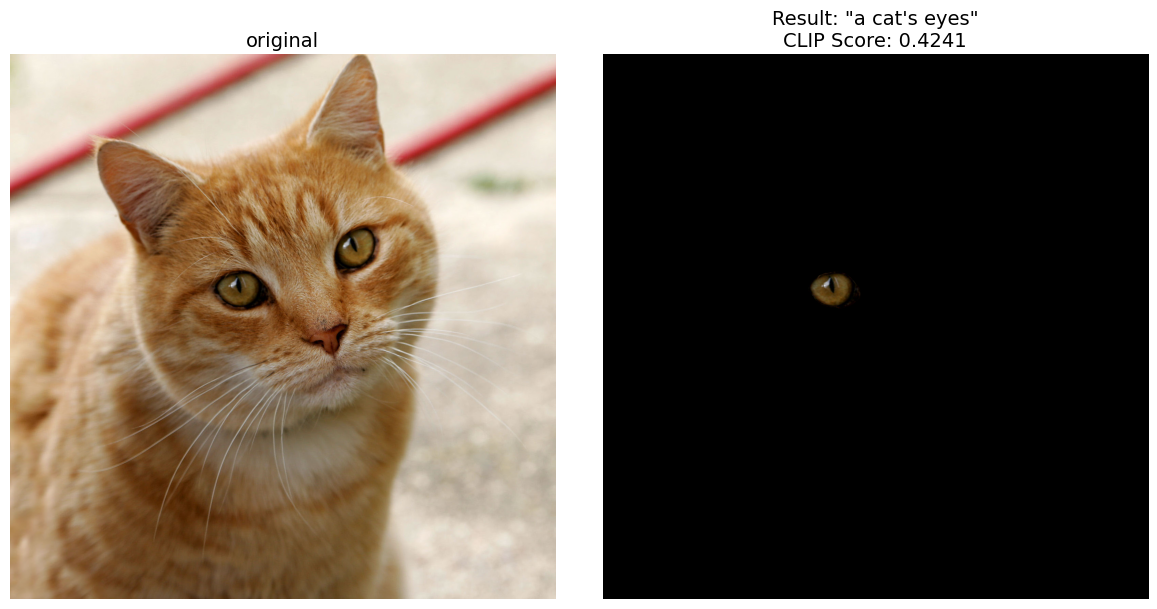


--- 正在测试提示词: "the cat's left ear" ---
  找到最佳蒙版，索引: 14，分数: 0.5298 (用时: 0.01s)


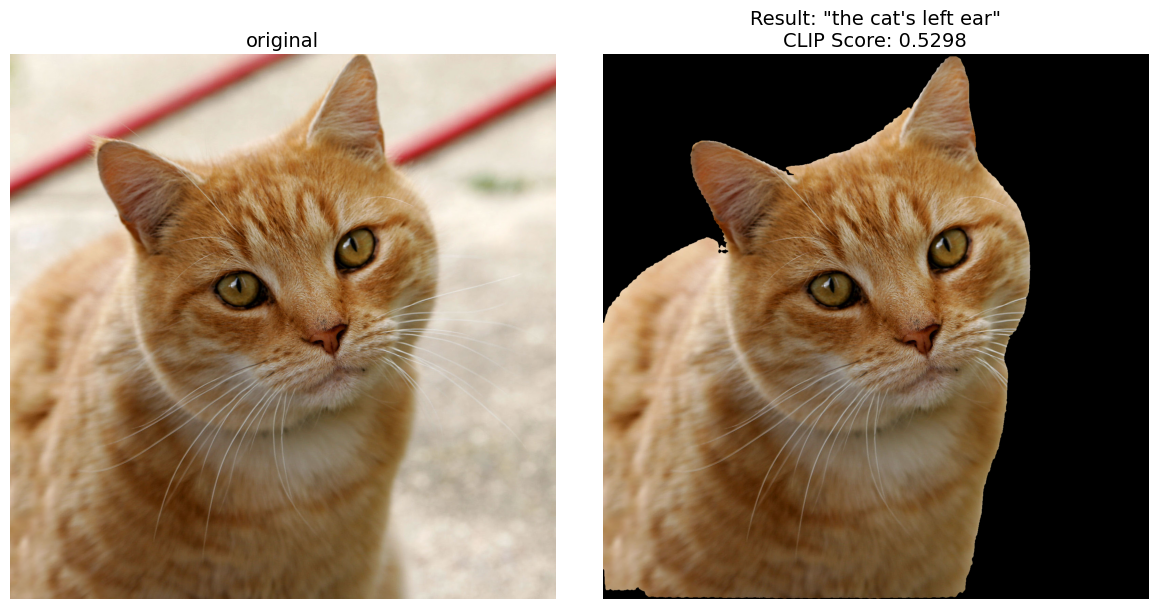


--- 正在测试提示词: "the cat's nose" ---
  找到最佳蒙版，索引: 14，分数: 0.3296 (用时: 0.01s)


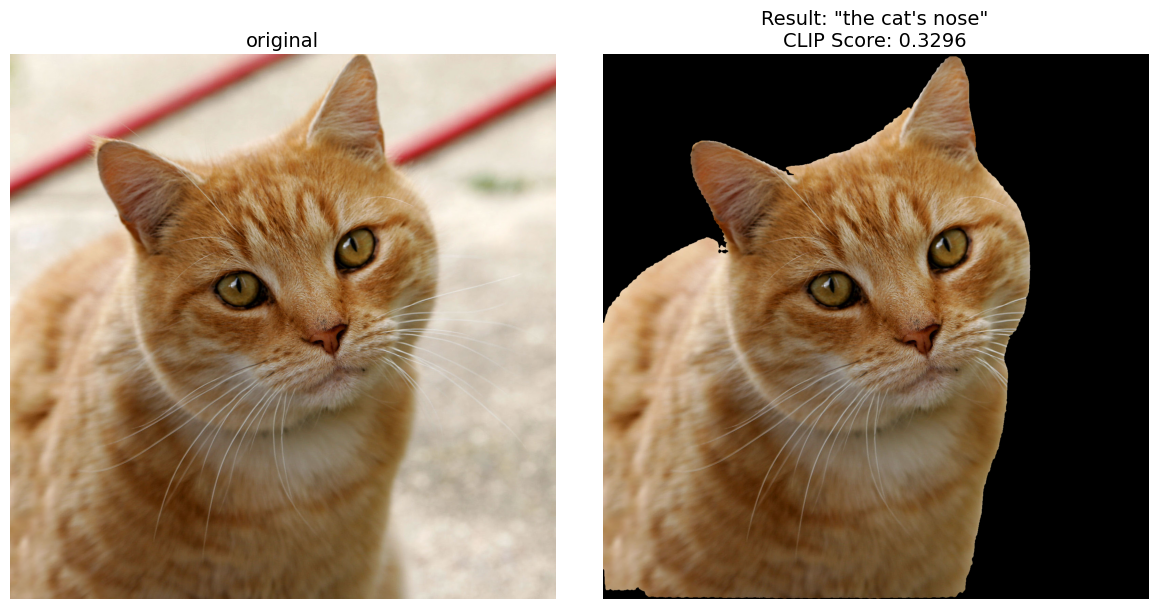


--- 正在测试提示词: "the blurry red background" ---
  找到最佳蒙版，索引: 7，分数: 0.4474 (用时: 0.01s)


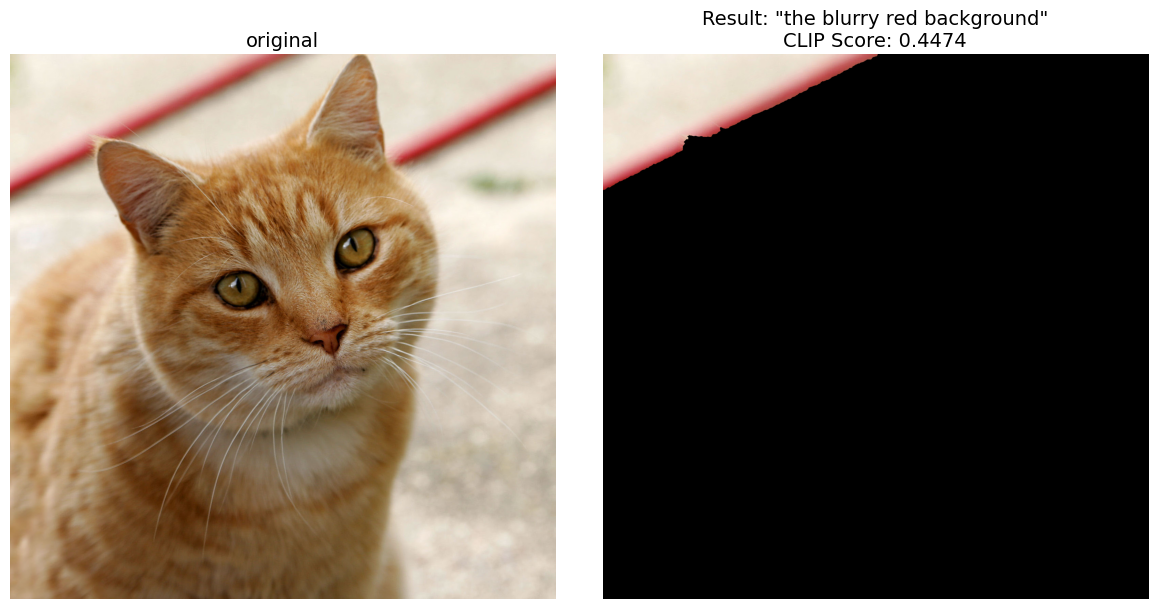

In [7]:
# ## 9. 提示词特异性研究 (Test Cell)
#
# 我们现在使用同一张猫的图片，但用更精细的提示词进行测试。

import time

# --- 1. 检查我们是否需要的数据都在 ---
if 'image_features' not in locals() or 'sam_masks' not in locals():
    print("错误: 找不到 'image_features' 或 'sam_masks'。")
    print("请确保你已经成功运行了 [步骤 5 & 6: CLIP 评分] 单元格。")
else:
    print(f"测试开始... (使用已缓存的 {len(sam_masks)} 个蒙版特征)")
    
    # --- 2. 定义你要测试的精细提示词 ---
    test_prompts = [
        "a cat's eyes",
        "the cat's left ear",
        "the cat's nose",
        "the blurry red background"
    ]

    # --- 3. 循环测试每一个提示词 ---
    for prompt in test_prompts:
        start_time = time.time()
        print(f"\n--- 正在测试提示词: \"{prompt}\" ---")
        
        with torch.no_grad():
            # a. 编码新的文本提示
            text = clip.tokenize([prompt]).to(clip_device)
            text_features = clip_model.encode_text(text)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            # b. 计算相似度 (重用 image_features)
            # (包含我们之前的 .float() MPS 修复)
            similarity = (100.0 * text_features.float() @ image_features.float().T).softmax(dim=-1)
            scores = similarity.squeeze()

            # c. 查找最佳匹配
            best_score, best_index = torch.max(scores, 0)
            best_mask_ann = sam_masks[best_index.item()]
            best_mask = best_mask_ann['segmentation']
            
            end_time = time.time()

            print(f"  找到最佳蒙版，索引: {best_index.item()}，分数: {best_score.item():.4f} (用时: {end_time - start_time:.2f}s)")
            
            # d. 显示结果
            # (注意: show_best_mask 会创建新图窗，我们最后统一显示)
            show_best_mask(image_rgb, best_mask, best_score.item(), prompt)

    # 确保所有 Matplotlib 图像都显示出来
    plt.show()

--- 正在为 "the cat's nose" 计算 Top-5 排名 ---
总共 15 个蒙版。正在显示排名前 5 的结果：


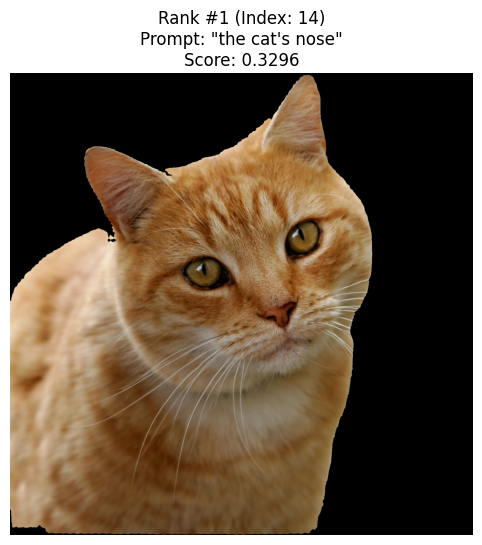

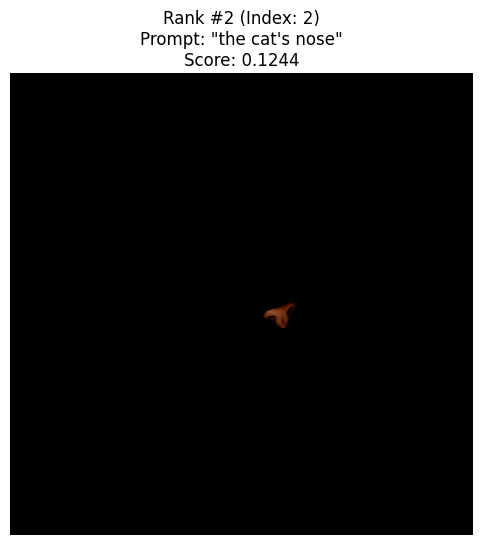

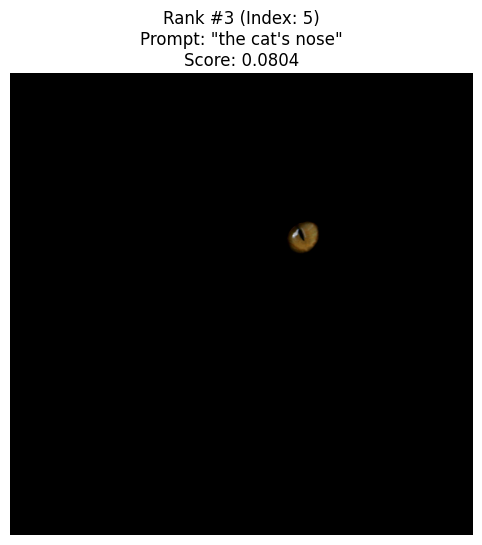

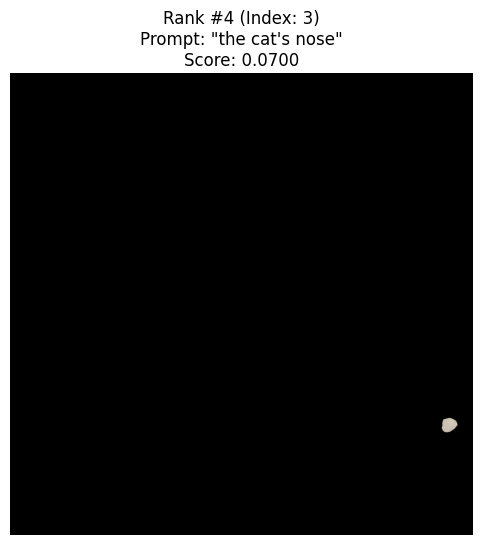

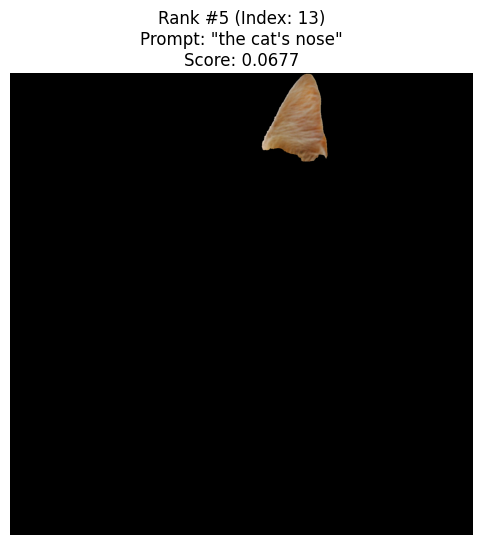

In [8]:

# ## 10. Visualization Top-K Ranking
import time

def show_ranked_mask(image, mask, title=""):
    plt.figure(figsize=(6, 6))
    result_image = np.zeros_like(image)
    result_image[mask] = image[mask]
    plt.imshow(result_image)
    plt.title(title, fontsize=12)
    plt.axis("off")
    plt.show() # 强制显示

# --- 1. 在这里定义你想看的提示词 ---
# PROMPT_TO_RANK = "a cat's eyes"
PROMPT_TO_RANK = "the cat's nose"
# PROMPT_TO_RANK = "the blurry red background"

TOP_K = 5 # 你想看排名前几位？

# --- 2. 检查所需变量是否存在 ---
if 'image_features' not in locals() or 'sam_masks' not in locals():
    print("错误: 找不到 'image_features' 或 'sam_masks'。")
    print("请确保你已经成功运行了 [步骤 5 & 6: CLIP 评分] 单元格。")
else:
    print(f"--- 正在为 \"{PROMPT_TO_RANK}\" 计算 Top-{TOP_K} 排名 ---")
    
    with torch.no_grad():
        # a. 编码文本提示
        text = clip.tokenize([PROMPT_TO_RANK]).to(clip_device)
        text_features = clip_model.encode_text(text)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # b. 计算所有蒙版的分数
        # (我们重用 'image_features'，这是所有蒙版的特征)
        similarity = (100.0 * text_features.float() @ image_features.float().T).softmax(dim=-1)
        scores = similarity.squeeze() # (N,)

        # c. (关键!) 排序所有分数
        # 'sorted_scores' 是分数, 'sorted_indices' 是它们在原始列表中的索引
        sorted_scores, sorted_indices = torch.sort(scores, descending=True)
        
        print(f"总共 {len(scores)} 个蒙版。正在显示排名前 {TOP_K} 的结果：")

        # d. 循环显示 Top-K
        for k in range(TOP_K):
            current_index = sorted_indices[k].item()
            current_score = sorted_scores[k].item()
            current_mask_ann = sam_masks[current_index]
            current_mask = current_mask_ann['segmentation']
            
            # 使用我们新的辅助函数来显示
            title = f"Rank #{k+1} (Index: {current_index})\nPrompt: \"{PROMPT_TO_RANK}\"\nScore: {current_score:.4f}"
            show_ranked_mask(image_rgb, current_mask, title=title)